## This notebook builds a probabilistic model with Pymc3 to extend the MSqRob ridge regression model
https://www.ncbi.nlm.nih.gov/pubmed/28391044
$$
y_{ijkl} = \beta_{ij}^{treatment} + \beta_{ik}^{peptide} + \beta_{il}^{run} + \epsilon_{in}
$$

where $y$ stands for the $log_2$-transformed intensity of each peptide $k$ in run $l$ and condition $j$ that belong to protein $i$. $n$ is the $n^{th}$ peptide and $\epsilon$ is an noise term following a normal distribution with $mu$ = 0 and sigma $\sigma_i$ specific to the protein.
Each $\beta$ models a different effect on the final intensity measurement. The treatment effect \beta^{treatment} can be regarded as an estimate of the $\log_2$ protein quantity. Thus, $\beta_{ij}^{treatment A} - \beta_{ij}^{treatment B}$ is an estimate of the $log_2$ fold change of protein $i$ between conditions A and B.

Independent ridge regression models are built for all N peptides under protein $i$.

In this notebook, the fold change of the proteins detected in the MaxLFQ proteomebenchmark dataset: https://www.ebi.ac.uk/pride/archive/projects/PXD000279 is modeled in a similar way with a new extension.

The peptides.txt file from MaxQuant was read in R and preprocessed with MSqRob preprocess_MaxQuant().

Sequence features are extracted from each peptide to better capture the sequence variability inherent to each peptide.
The sequence features were extracted using the protr package in R using extractAPAAC(), which yields a numeric vector of 32 features for each peptide, independent of length.
Additionally to these 3 features, the number of missed cleavages of the peptide, and an integer encoding the neighboring residues of the peptide in the protein were added to the features, giving 35 features in total.

The sequence features are used to model the peptide effect \beta_{ik}^{peptide}.

$$
\beta_{ik}^{peptide} = \theta * features_{ik}
$$

which multiplies the intensities $y$ in the ridge regression model above, rendering a new model:

$$
y_{ijkln} = \beta^{treatment}_{ij} \beta_{ik}^{peptide} + + \beta_{il}^{run} + \epsilon_{in}
$$


In [19]:
import pymc3 as pm
import theano

In [20]:
import pandas as pd
import os.path
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(123)
import seaborn as sns
sns.set_style('whitegrid')

In [21]:
# %load MSBay.py
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from theano import shared
import shutil
import os
from exp_annot_funcs import *


class MSBay:

    "Compile a MS-Bay model, load data into it and infer the posterior"

    def __init__(self, data, features):
       self.data = data
       self.features = features

    def compile_model(self, n_peptides, hierarchical_center=False, sequence=False):

        self.observed_sh  = shared(np.array([0.,]*6*n_peptides))
        self.feats_sh  = shared(np.array([[0.,]*9,]*n_peptides))
        self.x_treat_sh  = shared(np.array([[0.,]*2,]*6*n_peptides))
        self.x_pep_sh  = shared(np.array([[0.,]*n_peptides,]*6*n_peptides))
        self.x_run_sh  = shared(np.array([[0.,]*6,]*6*n_peptides))
        self.x_estimate_sh  = shared(np.array([[0.,]*2,]*1))
     
        # The number of proteins in this model is always one
        # i.e this model is fitted protein-wise
        n_prots = 1
        # The number of features is set to 9 for now
        # All peptides have 9 features, stored in feats_shared
        n_features = 9
        
    
        with pm.Model() as model:
               
            # Build a hyerarchical linear model of
            # log2(MS1 intensities) by accounting for:
    
                 # Peptide effect
                 # Run (batch) effect
                 # Treatment effect
                 # Remaining random effects
    
            # The difference in treatment effects is an estimate of the log2FC
    
    
            # Set a prior on the intercept
            intercept = pm.Normal("intercept", 22, 1)
            
            # Set a prior on the remaining random effects
            sigma = pm.HalfNormal('sigma', 1)
    
            ## Set priors on the peptide effect
            ################################################
            sigma_pep = pm.HalfNormal('sigma_pep', 1)
    
            # Not using the sequence
            if not sequence:
                mu_pep = pm.Normal('mu_pep', mu=0, sd=sigma_pep, shape=(n_peptides, 1))
    
            # Using the peptide sequence
            else: 
                # sequence based modelling
                mu_theta = pm.Normal('theta_generic', 0, sigma_pep, shape = 1)
                theta = pm.Normal('theta', mu_theta, sigma_pep, shape = (n_features, 1))    # 9x1
                theta_inter = pm.Normal('theta_inter', mu_theta, sigma_pep, shape = 1)
                mu_pep = pm.Deterministic("mu_pep", theta_inter + self.feats_sh.dot(theta)) # n_peptidesx1
    
    
            ## Set priors on the treatment and run effects
            ################################################    
            sigma_treat = pm.HalfNormal('sigma_treat', 1)
            mu_treat = pm.Normal('mu_treat', 0, sigma_treat)
            sigma_run = pm.HalfNormal('sigma_run', 1)
            mu_run = pm.Normal('mu_run', 0, sigma_run)
    
            # Standard implementation of the hyerarchies
            if hierarchical_center:
                pep = pm.Normal("pep", mu_pep, sigma_pep) # n_peptidesx1
                treat = pm.Normal('treat', mu_treat, sigma_treat, shape = (n_prots*2, 1))
                run = pm.Normal('run', mu_run, sigma_run, shape = (n_prots*6, 1))
    
            # Reparametrization to escape funnel of hell as noted in
            # http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/
            else:
                pep_offset = pm.Normal("pep_offset", mu=0, sd=1, shape = (n_peptides, 1))
                pep = pm.Deterministic("pep", mu_pep + pep_offset * sigma_pep)
                treat_offset = pm.Normal("treat_offset", mu=0, sd=1, shape=(n_prots*2, 1))
                treat = pm.Deterministic("treat", mu_treat + treat_offset*sigma_treat)
                run_offset = pm.Normal("run_offset", mu=0, sd=1, shape=(n_prots*6, 1))
                run = pm.Deterministic("run", mu_run + run_offset*sigma_run)
    
    
            # Model the effect for all peptides
            # The sh variables consist of -1,0,1 matrices telling pymc3
            # which parameters shall be used with each peptide
            # In practice, the "clone" each parameter to fit the shape of observed_sh
            # observed_sh is a n_peptides*6x1 tensor
            # The first 6 numbers store the MS1 intensities of the first peptide in the 6 runs
            # The next 6 those of the second peptide, and so on
    
            #estimate = pm.Deterministic('estimate', pm.math.sum(self.x_estimate_sh.dot(treat), axis=1))
            estimate = pm.Deterministic('estimate', self.x_estimate_sh.dot(treat))
            treatment_effect = pm.Deterministic("treatment_effect", pm.math.sum(self.x_treat_sh.dot(treat), axis=1))
            peptide_effect = pm.Deterministic("peptide_effect", pm.math.sum(self.x_pep_sh.dot(pep), axis=1))
            run_effect = pm.Deterministic("run_effect", pm.math.sum(self.x_run_sh.dot(run), axis=1))
    
            # BIND MODEL TO DATA
            mu = pm.Deterministic("mu", 
                intercept + treatment_effect + peptide_effect + run_effect) #n_peptides*6x1
            if hierarchical_center:
                obs = pm.Normal("obs", mu, sigma, observed=self.observed_sh)
            else:
                obs_offset = pm.Normal("obs_offset", mu=0, sd=1, shape=(n_peptides*6,1))
                obs = pm.Normal("obs", mu+obs_offset*sigma, sigma, observed=self.observed_sh)
    
    
        print("Success: Model compiled")

        self.model = model
        return model
    
    def sample(self, model_name, n_draws=1000, n_chains=3, remove_backend=True):
    
        # Check working environment  
        if not os.path.isdir("traces") or not os.path.isdir("plots/traceplots"):
            msg = "Please create a traces dir and a plots/traceplots dir before running this code"
            raise Exception(msg)
    
        if remove_backend and os.path.isdir("traces/{}".format(model_name)):
            shutil.rmtree("traces/{}".format(model_name))
    
    
        with self.model:
            # Parameters of the simulation:
            # Number of iterations and independent chains.
            n_sim = n_draws*n_chains
    
            # Save traces to the Text backend i.e a folder called
            # model_name containing csv files for each chain
            trace_name = 'traces/{}'.format(model_name)
            db = pm.backends.Text(trace_name)
            trace = pm.sample(draws=n_draws, njobs=n_chains, trace=db,
                              tune=2000, nuts_kwargs=dict(target_accept=.95))
        
        # Save a traceplot 
        pm.traceplot(trace, varnames=["estimate"])
        traceplot = "plots/traceplots/{}.png".format(model_name)
        plt.savefig(traceplot)
        plt.close()
           
        return trace

    def fit(self, model_name, n_draws):

        with self.model:
            
            inference = pm.ADVI()
            trace = pm.fit(n=n_draws, method=inference).sample()

        plt.plot(-inference.hist, alpha=.5)
        plt.legend()
        plt.ylabel('ELBO')
        plt.xlabel('iteration');
        plt.savefig("plots/ELBO/{}".format(model_name))
        plt.close()
        
        return trace
    
    def load_data(self, p):
    
        variables = create_variables(self.data, self.features, [p])
        observed, feats, x_treat, x_pep, x_run, x_estimate = variables
        self.observed_sh.set_value(observed)
        self.feats_sh.set_value(feats)    
        self.x_treat_sh.set_value(x_treat)
        self.x_pep_sh.set_value(x_pep)
        self.x_run_sh.set_value(x_run)
        self.x_estimate_sh.set_value(x_estimate)


In [22]:
data = pd.read_csv("data/data.tsv", sep = "\t")
data['H1'] = data['H1'].astype(theano.config.floatX)
data['H2'] = data['H2'].astype(theano.config.floatX)
data['H3'] = data['H3'].astype(theano.config.floatX)
data['L1'] = data['L1'].astype(theano.config.floatX)
data['L2'] = data['L2'].astype(theano.config.floatX)
data['L3'] = data['L3'].astype(theano.config.floatX)
data.head().drop("taxon", axis=1)

,protein,H1,H2,H3,L1,L2,L3
0,P37108,28.181535,28.006834,28.006941,27.133594,27.969390,27.869266
1,Q96P70,26.121057,25.893423,26.436157,25.421240,25.719706,25.811642
2,Q9Y2U8,22.398509,23.542741,24.042266,25.124118,25.285598,25.008512
3,Q9BTD8-4;Q9BTD8-2;Q9BTD8-3;Q9BTD8,23.337153,22.611060,23.675084,19.519606,23.237510,22.601230
4,Q9P258,22.545124,20.359925,22.185649,21.836265,22.880450,21.577547


[0.8469232  0.08723227]
[754.54590515 242.1599028 ]


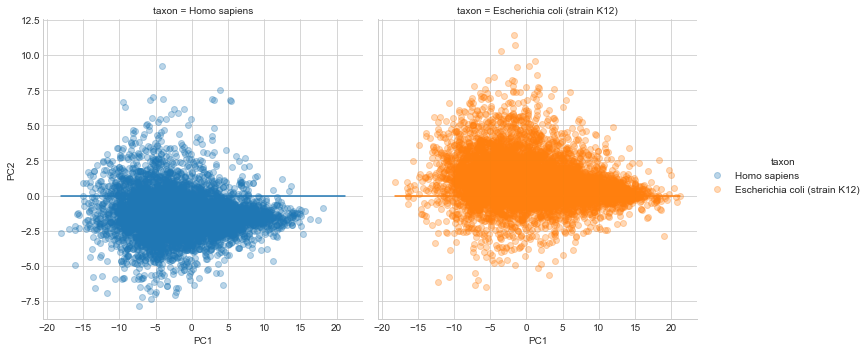

In [23]:
from sklearn.decomposition import PCA 
x = data.values[:,2:]
pca = PCA(n_components=2)
pca.fit(x)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
x_transformed = pca.transform(x)
pca_data = pd.DataFrame({"taxon": data.taxon, "PC1": x_transformed[:,0], "PC2": x_transformed[:,1]})
myPlot = sns.FacetGrid(col="taxon", hue='taxon', data=pca_data, size=5)
myPlot = myPlot.map(plt.scatter, "PC1", "PC2", alpha=0.3)
myPlot = myPlot.map_dataframe(plt.plot, [min(pca_data.PC1),max(pca_data.PC1)], [0, 0], 'r-').add_legend().set_axis_labels("PC1", "PC2")
plt.show()

In [ ]:
x=np.mean(data[["H1","H2","H3"]].values, axis=1)
y=np.mean(data[["L1","L2","L3"]].values, axis=1)
# colors=["red", "blue"]
# for i, taxon in enumerate(["Escherichia coli (strain K12)", "Homo sapiens"]):
#     plt.scatter(x=x[data.taxon == taxon],y=y[data.taxon == taxon], c=colors[i],label=taxon, alpha=0.5)
# def abline(slope, intercept):
#     """Plot a line from slope and intercept"""
#     axes = plt.gca()
#     x_vals = np.array(axes.get_xlim())
#     y_vals = intercept + slope * x_vals
#     plt.plot(x_vals, y_vals, '--',color="green")
# abline(1,0)
# plt.legend()
# plt.show()


In [ ]:
from numpy.linalg import norm
p1 = np.array([0,0])
p2 = np.array([1,1])
indices = [data.taxon == "Homo sapiens", data.taxon != "Homo sapiens"]
hsapiens_d, ecoli_d =np.array([[norm(np.cross(p2-p1, p1-p3))/norm(p2-p1) for p3 in zip(x[idx],y[idx])] for idx in indices])
print(np.mean(hsapiens_d))
print(np.mean(ecoli_d))

In [ ]:
features = pd.read_csv("data/advanced_features.tsv", sep = "\t").iloc[:,1:]
features=features.iloc[data.index,:]
n_seq_feat = features.shape[1]
print("Number of sequence features {}".format(n_seq_feat))
n_prots = len(np.unique(data.protein))
print("Number of proteins {}".format(n_prots))
n_peptides = data.shape[0]
print("Number of peptides {}".format(n_peptides))
print("This is the first row of the features array:")
print(features.shape)
print(features.iloc[:1,:])
features.head()

### Every protein has at least two peptides

In [ ]:
counts = np.unique(np.unique(data.protein, return_counts=True)[1], return_counts=True)
pd.DataFrame(np.array([counts[0], counts[1]]).T, columns = ["n_peptides", "n_prots"]).head(10)

In [ ]:
n_peptides = 2
prots, counts = np.unique(data.protein, return_counts=True)
prots = prots[counts == n_peptides]
data.loc[data.protein.isin(prots).values & (data.taxon == "Homo sapiens"),:].sort_values("protein").head(10)

### Load data

In [ ]:
msbay = MSBay(data, features)

### Instantiate model

In [ ]:
model = msbay.compile_model(n_peptides=n_peptides)

### Load data for specific protein

In [ ]:
msbay.load_data(p)

### Run model!!!!


In [ ]:
trace_nuts = msbay.sample(model_name=p,n_draws=1000, n_chains=3)

In [ ]:
trace_advi = msbay.fit(model_name=p, n_draws=50000)

In [ ]:
# traces=[]
# with model:
#     trace_name = "traces/{}".format(p)
#     print(trace_name)
#     trace = pm.backends.text.load(trace_name)
#     traces.append(trace)

In [ ]:
pm.plot_posterior(trace_nuts, varnames=["estimate"], ref_val=np.log2(3), color='LightSeaGreen', rope=[-0.4, 0.4])
plt.savefig("plots/posteriors/{}_nuts.png".format(p))
pm.plot_posterior(trace_advi, varnames=["estimate"], ref_val=np.log2(3), color='LightSeaGreen', rope=[-0.4, 0.4])
plt.savefig("plots/posteriors/{}_advi.png".format(p))

In [ ]:
pm.traceplot(trace_nuts, varnames=["estimate"])
pm.traceplot(trace_advi, varnames=["estimate"])

In [ ]:
from pymc3 import sample_ppc
with model:
    sim = sample_ppc(trace_advi, samples=500)["obs"]

In [ ]:
sim=sim[:,0,:]

In [ ]:
peps = list(map(lambda i: sim[:, (i*6):((i*6)+6)], range(n_peptides)))
estimates = list(map(lambda x: np.mean(x[:,:3], axis=1) - np.mean(x[:,3:6], axis=1), peps))
fig, ax = plt.subplots(1,n_peptides, figsize=(15,5))
[ax[i].hist(e) for i, e in enumerate(estimates)]
# [plt.hist(e, bins=30) for e in estimates]

In [ ]:
sim_transformed = pca.transform(np.vstack(peps))
sim_transformed
plt.scatter(sim_transformed[:,0], sim_transformed[:,1], label="Sim obs")
obs = data.loc[data.protein == p].iloc[:,2:]
obs_transformed = pca.transform(obs)
plt.scatter(obs_transformed[:,0], obs_transformed[:,1], c = "red", label="True obs")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

In [ ]:
prots, counts = np.unique(data.protein, return_counts=True)
proteins = {c: prots[counts == c] for c in counts}
test_prots = np.random.choice(proteins[2],size=10)

In [ ]:
test_prots

In [ ]:
traces = []
for p in test_prots:
    model = msbay.load_data(p)
    traces.append(msbay.fit(model_name=p,n_draws=50000))

In [ ]:
for i in range(len(test_prots)):
    pm.plot_posterior(traces[i], varnames=["estimate"], ref_val=np.log2(3), color='LightSeaGreen', rope=[-0.4, 0.4])
    plt.savefig("plots/posteriors/{}.png".format(test_prots[i]))
    plt.close()

In [ ]:
RSqM = pd.concat([pm.summary(traces[i], varnames=["estimate"]) for i in range(len(test_prots))])
RSqM.index = test_prots
RSqM.to_csv("data/RSqM.tsv", sep = "\t")

In [10]:
RSqM = pd.read_csv("data/RSqM.tsv", sep = "\t", index_col=0)
RSqM.head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5
P17275,0.024138,0.033738,0.001297,-0.025666,0.115376
P57740;G3V1T4,-0.135195,0.055406,0.002328,-0.240224,-0.028212
Q9H0U4;E9PLD0,0.303455,0.131120,0.006351,0.095746,0.581328
P52569;P52569-3;P52569-2,0.456605,0.180972,0.009014,0.128732,0.795744
P39298,1.868894,0.113901,0.005006,1.625516,2.066140


In [27]:
RSqM["taxon"] = [data.loc[data.protein == p,:]["taxon"].values[0] for p in RSqM.index.values]

In [28]:
%load_ext rpy2.ipython
%R library(ggplot2); library(tidyr); library(ggalt)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['ggalt', 'tidyr', 'ggplot2', 'tools', 'RevoUtils', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'],
      dtype='<U9')

In [30]:
%%R -i RSqM
RSqM$protein <- rownames(RSqM)
RSqM

                                mean         sd    mc_error     hpd_2.5
P17275                    0.02413839 0.03373756 0.001296929 -0.02566617
P57740;G3V1T4            -0.13519543 0.05540610 0.002327578 -0.24022447
Q9H0U4;E9PLD0             0.30345537 0.13111953 0.006351381  0.09574630
P52569;P52569-3;P52569-2  0.45660463 0.18097200 0.009014415  0.12873170
P39298                    1.86889359 0.11390069 0.005006212  1.62551629
Q9UKY1                    0.02666288 0.19223999 0.007679867 -0.35934216
Q9Y3D0                    0.73174491 0.34041936 0.016123430  0.17778857
P69228                    1.54103201 0.10068885 0.004611348  1.34987639
O00148                    0.28885393 0.11347340 0.005101664  0.10302127
P23003                    1.11931214 0.13918370 0.006885339  0.84907135
                           hpd_97.5                         taxon
P17275                    0.1153755                  Homo sapiens
P57740;G3V1T4            -0.0282122                  Homo sapiens
Q9H0U4;E9P

/home/antortjim/anaconda3/envs/bayesian/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/home/antortjim/anaconda3/envs/bayesian/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  Ignoring unknown parameters: point.colour.l

  warnings.warn(x, RRuntimeWarning)
/home/antortjim/anaconda3/envs/bayesian/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


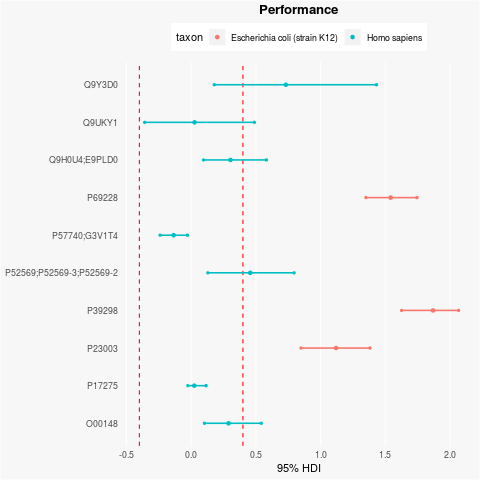

In [54]:
%%R
p <- ggplot(RSqM, aes(x=hpd_2.5, xend=hpd_97.5, y = protein, color=taxon)) +
       geom_vline(xintercept=-0.4, col="red", linetype="dashed") +
       geom_vline(xintercept=0.4, col="red", linetype="dashed") +
       geom_dumbbell(size=0.75,
                     point.colour.l="#0e668b") +
    geom_point(aes(x=mean, y = protein)) +
        labs(x=NULL, 
             y=NULL, 
             title="Performance" 
#              subtitle="Pct Change: 2013 vs 2014", 
#              caption="Source: https://github.com/hrbrmstr/ggalt"
            ) +        
    theme(plot.title = element_text(hjust=0.5, face="bold"),
              plot.background=element_rect(fill="#f7f7f7"),
              panel.background=element_rect(fill="#f7f7f7"),
              panel.grid.minor=element_blank(),
              panel.grid.major.y=element_blank(),
              panel.grid.major.x=element_line(),
              axis.ticks=element_blank(),
              legend.position="top",
              panel.border=element_blank()) +
    xlab("log2FC 95% HDI")
ggsave("plots/performance.png")
p